# Mount Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd drive/'My Drive'/repositories/moleculenet/notebooks

/content/drive/My Drive/repositories/moleculenet/lipophilicity


In [ ]:
%ls

ecfp4_features  ecfp6_pd.pkl            Lipo_README
ecfp4_pd.pkl    get_fingerprints.ipynb  rf_grid_search_on_fingerprints.ipynb
ecfp6_features  Lipophilicity.csv


# Import modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

In [ ]:
try:
    import forestci as fci
except ImportError as e:
    ! pip install forestci
    import forestci as fci

In [ ]:
print(fci.__version__)

0.3


# Load Data

In [ ]:
%ls ../data/

ESOL_README
FreeSolv_README
Lipo_README
esol_original.csv
esol_original_IdSmileTarget.csv
esol_original_ecfp4_features.csv
esol_original_ecfp6_features.csv
esol_original_extra_features.csv
esol_original_rdkit_features.csv
freesolv_original.csv
freesolv_original_IdSmileTarget.csv
freesolv_original_ecfp4_features.csv
freesolv_original_ecfp6_features.csv
freesolv_original_rdkit_features.csv
lipophilicity_original.csv
lipophilicity_original_IdSmileTarget.csv
lipophilicity_original_ecfp4_features.csv
lipophilicity_original_ecfp6_features.csv
lipophilicity_original_rdkit_features.csv
lipophilicity_original_smiles.smi
lipophilicity_original_smiles20.smi
lipophilicity_protonated_smiles20_messy.txt


In [ ]:
dataset = 'freesolv'
smile_type = 'original'

In [ ]:
# READ_ONLY
assert dataset in ['esol', 'freesolv', 'lipophilicity']
assert smile_type in ['original', 'protonated']

## Load Data

In [ ]:
%time

id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmileTarget.csv', index_col=0)
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)
ecfp4_features = pd.read_csv(f'../data/{dataset}_{smile_type}_ecfp4_features.csv', index_col=0)
ecfp6_features = pd.read_csv(f'../data/{dataset}_{smile_type}_ecfp6_features.csv', index_col=0)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


In [ ]:
id_smile_target.head()

smile  target
id                                                              
4-methoxy-N,N-dimethyl-benzamide  CN(C)C(=O)c1ccc(cc1)OC  -11.01
methanesulfonyl chloride                    CS(=O)(=O)Cl   -4.87
3-methylbut-1-ene                               CC(C)C=C    1.83
2-ethylpyrazine                               CCc1cnccn1   -5.45
heptan-1-ol                                     CCCCCCCO   -4.21

In [ ]:
rdkit_features.head()

MaxEStateIndex  MinEStateIndex  \
4-methoxy-N,N-dimethyl-benzamide       12.428170       -3.458874   
methanesulfonyl chloride                9.855710       -4.368056   
3-methylbut-1-ene                       7.349537       -3.289005   
2-ethylpyrazine                         7.363796       -3.006484   
heptan-1-ol                             7.581250       -4.173333   

                                  MaxAbsEStateIndex  MinAbsEStateIndex  \
4-methoxy-N,N-dimethyl-benzamide          12.428170           0.519264   
methanesulfonyl chloride                   9.855710           3.074846   
3-methylbut-1-ene                          7.349537           1.280324   
2-ethylpyrazine                            7.363796           0.587878   
heptan-1-ol                                7.581250           3.423878   

                                       qed    MolWt  HeavyAtomMolWt  \
4-methoxy-N,N-dimethyl-benzamide  0.686360  179.219         166.115   
methanesulfonyl chloride          0.421427  114.553         111.529   
3-methylbut-1-ene                 0.412737   70.135          60.055   
2-ethylpyrazine                   0.536795  108.144         100.080   
heptan-1-ol                       0.544191  116.204         100.076   

                                  ExactMolWt  NumValenceElectrons  \
4-methoxy-N,N-dimethyl-benzamide  179.094629                 70.0   
methanesulfonyl chloride          113.954228                 32.0   
3-methylbut-1-ene                  70.078250                 30.0   
2-ethylpyrazine                   108.068748                 42.0   
heptan-1-ol                       116.120115                 50.0   

                                  NumRadicalElectrons  ...  fr_sulfide  \
4-methoxy-N,N-dimethyl-benzamide                  0.0  ...         0.0   
methanesulfonyl chloride                          0.0  ...         0.0   
3-methylbut-1-ene                                 0.0  ...         0.0   
2-ethylpyrazine                                   0.0  ...         0.0   
heptan-1-ol                                       0.0  ...         0.0   

                                  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
4-methoxy-N,N-dimethyl-benzamide           0.0         0.0                0.0   
methanesulfonyl chloride                   0.0         0.0                0.0   
3-methylbut-1-ene                          0.0         0.0                0.0   
2-ethylpyrazine                            0.0         0.0                0.0   
heptan-1-ol                                0.0         0.0                0.0   

                                  fr_tetrazole  fr_thiazole  fr_thiocyan  \
4-methoxy-N,N-dimethyl-benzamide           0.0          0.0          0.0   
methanesulfonyl chloride                   0.0          0.0          0.0   
3-methylbut-1-ene                          0.0          0.0          0.0   
2-ethylpyrazine                            0.0          0.0          0.0   
heptan-1-ol                                0.0          0.0          0.0   

                                  fr_thiophene  fr_unbrch_alkane  fr_urea  
4-methoxy-N,N-dimethyl-benzamide           0.0               0.0      0.0  
methanesulfonyl chloride                   0.0               0.0      0.0  
3-methylbut-1-ene                          0.0               0.0      0.0  
2-ethylpyrazine                            0.0               0.0      0.0  
heptan-1-ol                                0.0               0.0      0.0  

[5 rows x 200 columns]

In [ ]:
ecfp4_features.head()

0  1  2  3  4  5  6  7  8  9  ...  2038  \
4-methoxy-N,N-dimethyl-benzamide  0  0  0  0  0  0  0  0  0  0  ...     0   
methanesulfonyl chloride          0  0  0  0  0  0  0  0  0  0  ...     0   
3-methylbut-1-ene                 0  1  0  0  0  0  0  0  0  0  ...     0   
2-ethylpyrazine                   0  0  0  0  0  0  0  0  0  0  ...     0   
heptan-1-ol                       0  0  0  0  0  0  0  0  0  0  ...     0   

                                  2039  2040  2041  2042  2043  2044  2045  \
4-methoxy-N,N-dimethyl-benzamide     0     0     0     0     0     0     0   
methanesulfonyl chloride             0     0     0     0     0     0     0   
3-methylbut-1-ene                    0     0     0     0     0     0     0   
2-ethylpyrazine                      0     0     0     0     0     0     0   
heptan-1-ol                          0     0     0     0     0     0     0   

                                  2046  2047  
4-methoxy-N,N-dimethyl-benzamide     0     0  
methanesulfonyl chloride             0     0  
3-methylbut-1-ene                    0     0  
2-ethylpyrazine                      0     0  
heptan-1-ol                          0     0  

[5 rows x 2048 columns]

In [ ]:
ecfp6_features.head()

0  1  2  3  4  5  6  7  8  9  ...  2038  \
4-methoxy-N,N-dimethyl-benzamide  0  0  0  0  0  0  0  0  0  0  ...     0   
methanesulfonyl chloride          0  0  0  0  0  0  0  0  0  0  ...     0   
3-methylbut-1-ene                 0  1  0  0  0  0  0  0  0  0  ...     0   
2-ethylpyrazine                   0  0  0  0  0  0  0  0  0  0  ...     0   
heptan-1-ol                       0  0  0  0  0  0  0  0  0  0  ...     0   

                                  2039  2040  2041  2042  2043  2044  2045  \
4-methoxy-N,N-dimethyl-benzamide     0     0     0     0     0     0     0   
methanesulfonyl chloride             0     0     0     0     0     0     0   
3-methylbut-1-ene                    0     0     0     0     0     0     0   
2-ethylpyrazine                      0     0     0     0     0     0     0   
heptan-1-ol                          0     0     0     0     0     0     0   

                                  2046  2047  
4-methoxy-N,N-dimethyl-benzamide     0     0  
methanesulfonyl chloride             0     0  
3-methylbut-1-ene                    0     0  
2-ethylpyrazine                      0     0  
heptan-1-ol                          0     0  

[5 rows x 2048 columns]

## Get target

In [ ]:
target = id_smile_target['target']
target.head()

id
4-methoxy-N,N-dimethyl-benzamide   -11.01
methanesulfonyl chloride            -4.87
3-methylbut-1-ene                    1.83
2-ethylpyrazine                     -5.45
heptan-1-ol                         -4.21
Name: target, dtype: float64

# Run a vanilla RF on ECFP-4

In [ ]:
X = ecfp4_features
y = target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1,
                           verbose = 1)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [ ]:
y_hat = rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


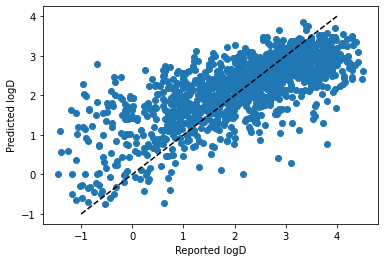

In [ ]:
# Plot predicted pK without error bars
plt.scatter(y_test, y_hat)
plt.plot([-1, 4], [-1, 4], 'k--')
plt.xlabel('Reported logD')
plt.ylabel('Predicted logD')
plt.show()

In [ ]:
# Calculate the variance
V_IJ_unbiased = fci.random_forest_error(rf, X_train, X_test)

In [ ]:
print(len(V_IJ_unbiased))
V_IJ_unbiased[:20]

1386


array([3.12646491, 2.89410998, 4.58686917, 2.82715842, 2.57799845,
       3.04036183, 3.76456776, 2.47692172, 2.88963433, 2.7805091 ,
       2.83741528, 3.09161856, 2.76960449, 2.74806308, 2.91823807,
       2.80452124, 3.15282237, 2.66001476, 2.75192303, 2.80356816])

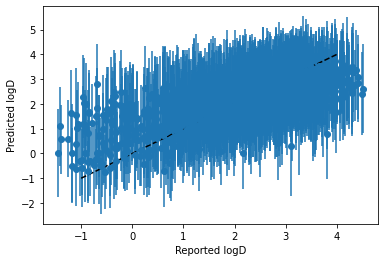

In [ ]:
# Plot error bars for predicted pK using unbiased variance
plt.errorbar(x=y_test, y=y_hat, yerr=np.sqrt(V_IJ_unbiased), fmt='o')
plt.plot([-1, 4], [-1, 4], 'k--')
plt.xlabel('Reported logD')
plt.ylabel('Predicted logD')
plt.show()